In [1]:
from keras.models import Sequential, load_model
from keras.layers import Dense, Activation, LSTM, Conv1D, MaxPooling1D, UpSampling1D, Flatten, Reshape, ZeroPadding1D, Cropping1D
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import Adam
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.python.keras import backend as K
import gc
import tensorflow as tf
import random
from sklearn import preprocessing
import pickle
import math

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

Using TensorFlow backend.


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 9583903607575301506
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 9105744200
locality {
  bus_id: 1
  links {
  }
}
incarnation: 3013583170029521808
physical_device_desc: "device: 0, name: GeForce RTX 2080 Ti, pci bus id: 0000:02:00.0, compute capability: 7.5"
]


### Load Data

In [2]:
training_set = None

with open('dataset/tuning_set.pickle', 'rb') as data:
    training_set = pickle.load(data)

### Training set preparation

In [3]:
trainingSet = list()
for entry in training_set:
    for i in range(48):
        trainingSet.append(list(entry[i:i+48,:]))
trainingSet = np.array(trainingSet)
sequenceLen = trainingSet.shape[1] # in training
trainDataSize = trainingSet.shape[0]
dimensionsCount = 6

LSTMTraining_data = np.reshape(trainingSet, (trainDataSize,sequenceLen,dimensionsCount), order='C')
FlattenedTrainingData = np.reshape(trainingSet, (trainDataSize,sequenceLen*dimensionsCount,1), order='C')
fullyConnectedTrainingData = np.reshape(trainingSet, (trainDataSize,sequenceLen*dimensionsCount), order='C')

### 1D Convolutional Network

In [4]:
def train1DConv(numOfHiddenLayersInEncoder, FiltersCountInFirstLayer = 32, printSummary = 1, vrbs = 1, return_best = 0, filterSize = 3, learningRate = 0.001):    
    numOfHiddenLayersInEncoder = numOfHiddenLayersInEncoder + 1
    model = Sequential()    
    poolingSize = 2
    numOfFiltersInEncoder = [FiltersCountInFirstLayer]
    paddingSize = (filterSize // 2)
    inputLen = (sequenceLen * dimensionsCount)
    paddedInputLength = inputLen + (paddingSize*2)
    encoderLayersFilterSizes = [paddedInputLength]
    model.add(ZeroPadding1D(paddingSize,input_shape=(sequenceLen * dimensionsCount,1)))
    model.add(Conv1D(int(FiltersCountInFirstLayer), filterSize, activation='relu', padding = 'same'))
    for i in range(1,numOfHiddenLayersInEncoder):
        model.add(MaxPooling1D(poolingSize, padding='same'))
        model.add(Conv1D(int(FiltersCountInFirstLayer*np.power(2,i)), filterSize, activation='relu', padding = 'same'))
        
        encoderLayersFilterSizes.append(int(np.ceil(paddedInputLength/np.power(2,i))))
        numOfFiltersInEncoder.append(int(FiltersCountInFirstLayer*np.power(2,i)))
    model.add(Flatten())
    model.add(Reshape((encoderLayersFilterSizes[-1], numOfFiltersInEncoder[-1])))
    for j in range(1,numOfHiddenLayersInEncoder):    
        model.add(Conv1D(numOfFiltersInEncoder[-j], filterSize, activation='relu', padding = 'same'))
        model.add(UpSampling1D(poolingSize))

    model.add(Conv1D(numOfFiltersInEncoder[0], filterSize, activation='relu', padding='same'))
    model.add(Conv1D(1, filterSize, activation='linear', padding='same'))
    
    toCrop = (model.layers[-1].output_shape[1] - inputLen) // 2
    
    model.add(Cropping1D(toCrop))
    model.summary()

    adamOptimizer = Adam(learning_rate=learningRate) # , beta_1=0.9, beta_2=0.999, amsgrad=False            
    model.compile(optimizer=adamOptimizer,
        loss='mean_squared_error',
    )

    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience = 10)
    callbacksArray = [es]
    if(return_best):
        mc = ModelCheckpoint('best_1DConv.h5', monitor='val_loss', mode='min')
        callbacksArray = [es, mc]

    history=model.fit(FlattenedTrainingData, FlattenedTrainingData,
                        batch_size=1000, # normally 500 but for filter count tuning 
                        epochs=1000, 
                        shuffle=True,
                        validation_split=0.1,
                        callbacks=callbacksArray,
                        )
    if(return_best):
        best_model = load_model('best_1DConv.h5')
        
    returnModel = model
    if(return_best):
        returnModel = best_model
    return [returnModel,min(history.history['val_loss']),len(history.history['val_loss']),history]

### 1D Convolutional Learning Rate Tuning

In [21]:
modelsLoss = []
modelsEpochs = []
for i in [0.01, 0.001]:
    lr = i
    numOfLayers = 2
    filtersCountInFirstLayer = 32
    [model, validatoinLoss, numOfEpochs, _] = train1DConv(numOfLayers, filtersCountInFirstLayer,learningRate = lr)
    modelsLoss.append(validatoinLoss)
    modelsEpochs.append(numOfEpochs)

1
Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_padding1d_1 (ZeroPaddin (None, 290, 1)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 290, 32)           128       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 145, 32)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 145, 64)           6208      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 73, 64)            0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 73, 128)           24704     
_________________________________________________________________
flatten_1 (Flatten)          (None, 9344)           

Epoch 54/1000
43200/43200 [==============================] - 2s 52us/step - loss: 5.1807e-04 - val_loss: 4.9995e-04
Epoch 55/1000
43200/43200 [==============================] - 2s 51us/step - loss: 5.1554e-04 - val_loss: 5.0453e-04
Epoch 56/1000
43200/43200 [==============================] - 2s 52us/step - loss: 5.4028e-04 - val_loss: 5.2503e-04
Epoch 57/1000
43200/43200 [==============================] - 2s 52us/step - loss: 4.4555e-04 - val_loss: 5.4082e-04
Epoch 58/1000
43200/43200 [==============================] - 2s 52us/step - loss: 4.6094e-04 - val_loss: 5.0749e-04
Epoch 59/1000
43200/43200 [==============================] - 2s 53us/step - loss: 4.6821e-04 - val_loss: 4.8626e-04
Epoch 60/1000
43200/43200 [==============================] - 2s 54us/step - loss: 4.5168e-04 - val_loss: 3.9133e-04
Epoch 61/1000
43200/43200 [==============================] - 2s 52us/step - loss: 4.2347e-04 - val_loss: 4.4630e-04
Epoch 62/1000
43200/43200 [==============================] - 2s 52us/ste

Epoch 78/1000
43200/43200 [==============================] - 2s 52us/step - loss: 1.4092e-05 - val_loss: 1.0082e-05
Epoch 79/1000
43200/43200 [==============================] - 2s 57us/step - loss: 2.5777e-05 - val_loss: 1.8405e-04
Epoch 80/1000
43200/43200 [==============================] - 2s 55us/step - loss: 3.2722e-05 - val_loss: 1.1152e-05
Epoch 81/1000
43200/43200 [==============================] - 2s 54us/step - loss: 4.3035e-05 - val_loss: 3.9074e-05
Epoch 82/1000
43200/43200 [==============================] - 2s 54us/step - loss: 1.9831e-05 - val_loss: 8.8543e-06
Epoch 83/1000
43200/43200 [==============================] - 2s 54us/step - loss: 3.0597e-05 - val_loss: 1.2160e-05
Epoch 84/1000
43200/43200 [==============================] - 2s 54us/step - loss: 2.0022e-05 - val_loss: 4.5846e-05
Epoch 85/1000
43200/43200 [==============================] - 2s 55us/step - loss: 3.9876e-05 - val_loss: 1.3423e-05
Epoch 86/1000
43200/43200 [==============================] - 2s 53us/ste

[0.00024354380063111117, 6.744936683844571e-06]


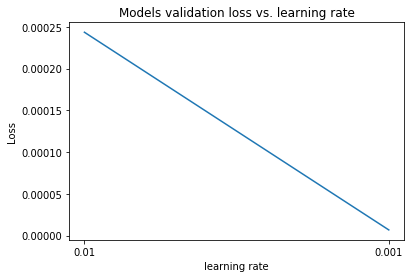

<Figure size 432x288 with 0 Axes>

In [22]:
print(modelsLoss)

plt.plot(modelsLoss)
plt.title('Models validation loss vs. learning rate')
plt.ylabel('Loss')
plt.xlabel('learning rate')
plt.xticks(np.arange(2), [0.01, 0.001])
plt.show()
plt.savefig('figures_differential/1D_conv_learning_rate_tuning.eps', format='eps', dpi=300, bbox_inches='tight')

### 1-D Convolutional Network Depth tune


In [5]:
modelsLoss = []
modelsEpochs = []
for i in range(1,6):
    numOfLayers = i
    filtersCountInFirstLayer = 32
    [model, validatoinLoss, numOfEpochs, _] = train1DConv(numOfLayers, filtersCountInFirstLayer)
    modelsLoss.append(validatoinLoss)
    modelsEpochs.append(numOfEpochs)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_padding1d_1 (ZeroPaddin (None, 290, 1)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 290, 32)           128       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 145, 32)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 145, 64)           6208      
_________________________________________________________________
flatten_1 (Flatten)          (None, 9280)              0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 145, 64)           0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 145, 64)          

Epoch 56/1000
43200/43200 [==============================] - 2s 35us/step - loss: 7.1360e-06 - val_loss: 7.0047e-06
Epoch 57/1000
43200/43200 [==============================] - 2s 36us/step - loss: 2.6347e-05 - val_loss: 7.7596e-06
Epoch 58/1000
43200/43200 [==============================] - 2s 35us/step - loss: 7.8596e-06 - val_loss: 6.8229e-06
Epoch 59/1000
43200/43200 [==============================] - 2s 35us/step - loss: 6.7825e-06 - val_loss: 6.6624e-06
Epoch 60/1000
43200/43200 [==============================] - 2s 36us/step - loss: 1.6110e-05 - val_loss: 6.8838e-06
Epoch 61/1000
43200/43200 [==============================] - 2s 35us/step - loss: 7.9928e-06 - val_loss: 9.2124e-06
Epoch 62/1000
43200/43200 [==============================] - 2s 35us/step - loss: 1.5299e-05 - val_loss: 8.2032e-06
Epoch 63/1000
43200/43200 [==============================] - 2s 35us/step - loss: 1.3885e-05 - val_loss: 1.6432e-05
Epoch 64/1000
43200/43200 [==============================] - 2s 35us/ste

Train on 43200 samples, validate on 4800 samples
Epoch 1/1000
43200/43200 [==============================] - 4s 86us/step - loss: 0.0531 - val_loss: 0.0286
Epoch 2/1000
43200/43200 [==============================] - 2s 51us/step - loss: 0.0194 - val_loss: 0.0036
Epoch 3/1000
43200/43200 [==============================] - 2s 50us/step - loss: 0.0026 - val_loss: 0.0020
Epoch 4/1000
43200/43200 [==============================] - 2s 50us/step - loss: 0.0017 - val_loss: 0.0013
Epoch 5/1000
43200/43200 [==============================] - 2s 52us/step - loss: 0.0011 - val_loss: 0.0010
Epoch 6/1000
43200/43200 [==============================] - 2s 52us/step - loss: 0.0010 - val_loss: 9.5237e-04
Epoch 7/1000
43200/43200 [==============================] - 2s 51us/step - loss: 9.0485e-04 - val_loss: 8.5663e-04
Epoch 8/1000
43200/43200 [==============================] - 2s 50us/step - loss: 7.9820e-04 - val_loss: 6.9456e-04
Epoch 9/1000
43200/43200 [==============================] - 2s 50us/step - 

43200/43200 [==============================] - 3s 66us/step - loss: 6.8236e-06 - val_loss: 5.5738e-06
Epoch 142/1000
43200/43200 [==============================] - 3s 68us/step - loss: 5.2909e-06 - val_loss: 5.9294e-06
Epoch 143/1000
43200/43200 [==============================] - 2s 54us/step - loss: 3.2092e-05 - val_loss: 8.9102e-06
Epoch 144/1000
43200/43200 [==============================] - 2s 51us/step - loss: 6.5894e-06 - val_loss: 5.4095e-06
Epoch 145/1000
43200/43200 [==============================] - 3s 64us/step - loss: 1.5412e-05 - val_loss: 3.5281e-05
Epoch 146/1000
43200/43200 [==============================] - 3s 71us/step - loss: 1.0111e-05 - val_loss: 5.9002e-06
Epoch 147/1000
43200/43200 [==============================] - 2s 49us/step - loss: 2.8481e-05 - val_loss: 1.2653e-05
Epoch 148/1000
43200/43200 [==============================] - 2s 49us/step - loss: 7.2495e-06 - val_loss: 5.1410e-06
Epoch 149/1000
43200/43200 [==============================] - 2s 49us/step - lo

Epoch 46/1000
43200/43200 [==============================] - 3s 73us/step - loss: 6.8939e-05 - val_loss: 2.0029e-04
Epoch 47/1000
43200/43200 [==============================] - 3s 74us/step - loss: 5.3266e-05 - val_loss: 3.5287e-05
Epoch 48/1000
43200/43200 [==============================] - 3s 73us/step - loss: 7.4362e-05 - val_loss: 7.1250e-05
Epoch 49/1000
43200/43200 [==============================] - 3s 72us/step - loss: 4.0699e-05 - val_loss: 1.0543e-04
Epoch 50/1000
43200/43200 [==============================] - 3s 71us/step - loss: 7.7746e-05 - val_loss: 3.2588e-05
Epoch 51/1000
43200/43200 [==============================] - 3s 71us/step - loss: 7.5598e-05 - val_loss: 7.5713e-04
Epoch 52/1000
43200/43200 [==============================] - 3s 73us/step - loss: 1.0616e-04 - val_loss: 3.1075e-05
Epoch 53/1000
43200/43200 [==============================] - 3s 73us/step - loss: 2.8319e-05 - val_loss: 2.8401e-05
Epoch 54/1000
43200/43200 [==============================] - 3s 73us/ste

Epoch 186/1000
43200/43200 [==============================] - 3s 71us/step - loss: 5.6919e-06 - val_loss: 5.3930e-06
Epoch 187/1000
43200/43200 [==============================] - 3s 71us/step - loss: 5.1119e-06 - val_loss: 5.3075e-06
Epoch 188/1000
43200/43200 [==============================] - 3s 71us/step - loss: 3.0591e-05 - val_loss: 2.7947e-05
Epoch 189/1000
43200/43200 [==============================] - 3s 71us/step - loss: 8.6839e-06 - val_loss: 5.3573e-06
Epoch 190/1000
43200/43200 [==============================] - 3s 71us/step - loss: 5.0982e-06 - val_loss: 5.8369e-06
Epoch 191/1000
43200/43200 [==============================] - 3s 71us/step - loss: 1.6136e-05 - val_loss: 1.3289e-05
Epoch 192/1000
43200/43200 [==============================] - 3s 71us/step - loss: 7.1732e-06 - val_loss: 8.2090e-06
Epoch 193/1000
43200/43200 [==============================] - 3s 71us/step - loss: 2.7496e-05 - val_loss: 1.1057e-05
Epoch 194/1000
43200/43200 [==============================] - 3s

43200/43200 [==============================] - 4s 102us/step - loss: 8.1722e-05 - val_loss: 2.2115e-05
Epoch 91/1000
43200/43200 [==============================] - 4s 101us/step - loss: 1.8440e-05 - val_loss: 1.8188e-05
Epoch 92/1000
43200/43200 [==============================] - 4s 101us/step - loss: 4.0184e-05 - val_loss: 1.6318e-04
Epoch 93/1000
43200/43200 [==============================] - 4s 101us/step - loss: 3.4518e-05 - val_loss: 1.7822e-05
Epoch 94/1000
43200/43200 [==============================] - 4s 102us/step - loss: 5.3101e-05 - val_loss: 4.5746e-05
Epoch 95/1000
43200/43200 [==============================] - 5s 114us/step - loss: 2.9148e-05 - val_loss: 1.7226e-05
Epoch 96/1000
43200/43200 [==============================] - 5s 106us/step - loss: 1.6796e-05 - val_loss: 1.8138e-05
Epoch 97/1000
43200/43200 [==============================] - 5s 108us/step - loss: 8.7052e-05 - val_loss: 2.3892e-05
Epoch 98/1000
43200/43200 [==============================] - 4s 102us/step - l

Epoch 16/1000
43200/43200 [==============================] - 7s 158us/step - loss: 0.0016 - val_loss: 0.0014
Epoch 17/1000
43200/43200 [==============================] - 7s 159us/step - loss: 0.0013 - val_loss: 0.0013
Epoch 18/1000
43200/43200 [==============================] - 7s 159us/step - loss: 0.0011 - val_loss: 0.0010
Epoch 19/1000
43200/43200 [==============================] - 7s 156us/step - loss: 9.9498e-04 - val_loss: 7.9213e-04
Epoch 20/1000
43200/43200 [==============================] - 7s 159us/step - loss: 8.0351e-04 - val_loss: 7.3659e-04
Epoch 21/1000
43200/43200 [==============================] - 7s 156us/step - loss: 7.1658e-04 - val_loss: 6.5575e-04
Epoch 22/1000
43200/43200 [==============================] - 7s 152us/step - loss: 6.5501e-04 - val_loss: 6.1767e-04
Epoch 23/1000
43200/43200 [==============================] - 7s 158us/step - loss: 6.5547e-04 - val_loss: 6.0410e-04
Epoch 24/1000
43200/43200 [==============================] - 7s 163us/step - loss: 4.656

43200/43200 [==============================] - 6s 149us/step - loss: 1.6851e-05 - val_loss: 1.4725e-05
Epoch 156/1000
43200/43200 [==============================] - 6s 148us/step - loss: 3.2623e-05 - val_loss: 2.2548e-05
Epoch 157/1000
43200/43200 [==============================] - 6s 148us/step - loss: 2.6298e-05 - val_loss: 1.7467e-05
Epoch 158/1000
43200/43200 [==============================] - 6s 149us/step - loss: 2.4806e-05 - val_loss: 2.7355e-04
Epoch 159/1000
43200/43200 [==============================] - 6s 149us/step - loss: 4.9706e-05 - val_loss: 1.5483e-05
Epoch 160/1000
43200/43200 [==============================] - 6s 150us/step - loss: 1.3978e-05 - val_loss: 1.3749e-05
Epoch 161/1000
43200/43200 [==============================] - 6s 149us/step - loss: 1.8644e-05 - val_loss: 2.1044e-05
Epoch 162/1000
43200/43200 [==============================] - 6s 148us/step - loss: 3.7610e-05 - val_loss: 1.6882e-05
Epoch 163/1000
43200/43200 [==============================] - 6s 148us/

[4.312497897747865e-06, 3.279004251529235e-06, 4.797896716960774e-06, 1.5865972576042015e-05, 6.447064947678882e-06]
[107, 211, 207, 111, 261]


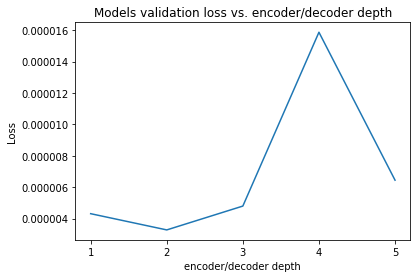

<Figure size 432x288 with 0 Axes>

In [6]:
print(modelsLoss)
print(modelsEpochs)

plt.plot(modelsLoss)
#plt.plot(history.history['val_loss'])
plt.title('Models validation loss vs. encoder/decoder depth')
plt.ylabel('Loss')
plt.xlabel('encoder/decoder depth')
plt.xticks(np.arange(5), [1,2,3,4,5])
#plt.legend(['validation'], loc='upper left')
plt.show()
plt.savefig('figures_differential/conv_depth_tuning.eps', format='eps', dpi=300, bbox_inches='tight')


In [ ]:
depthParam = modelsLoss.index(min(modelsLoss)) + 1

### 1-D Convolutional Network filter size tuning


In [8]:
modelsLoss = []
modelsEpochs = []
for i in range(2,10,1):
    numOfLayers = depthParam
    filtersCountInFirstLayer = 32
    [model, validatoinLoss, numOfEpochs, _] = train1DConv(numOfLayers, filtersCountInFirstLayer, filterSize = i)
    modelsLoss.append(validatoinLoss)
    modelsEpochs.append(numOfEpochs)

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_padding1d_6 (ZeroPaddin (None, 290, 1)            0         
_________________________________________________________________
conv1d_46 (Conv1D)           (None, 290, 32)           96        
_________________________________________________________________
max_pooling1d_16 (MaxPooling (None, 145, 32)           0         
_________________________________________________________________
conv1d_47 (Conv1D)           (None, 145, 64)           4160      
_________________________________________________________________
max_pooling1d_17 (MaxPooling (None, 73, 64)            0         
_________________________________________________________________
conv1d_48 (Conv1D)           (None, 73, 128)           16512     
_________________________________________________________________
flatten_6 (Flatten)          (None, 9344)             

43200/43200 [==============================] - 2s 52us/step - loss: 1.9421e-04 - val_loss: 2.1175e-04
Epoch 122/1000
43200/43200 [==============================] - 2s 54us/step - loss: 1.8938e-04 - val_loss: 1.9254e-04
Epoch 123/1000
43200/43200 [==============================] - 2s 55us/step - loss: 1.9020e-04 - val_loss: 2.0814e-04
Epoch 124/1000
43200/43200 [==============================] - 2s 54us/step - loss: 1.9070e-04 - val_loss: 1.8372e-04
Epoch 125/1000
43200/43200 [==============================] - 2s 53us/step - loss: 2.0851e-04 - val_loss: 2.3731e-04
Epoch 126/1000
43200/43200 [==============================] - 2s 52us/step - loss: 1.8903e-04 - val_loss: 1.8348e-04
Epoch 127/1000
43200/43200 [==============================] - 2s 52us/step - loss: 1.8746e-04 - val_loss: 1.8592e-04
Epoch 128/1000
43200/43200 [==============================] - 2s 52us/step - loss: 1.8039e-04 - val_loss: 1.8334e-04
Epoch 129/1000
43200/43200 [==============================] - 2s 52us/step - lo

Train on 43200 samples, validate on 4800 samples
Epoch 1/1000
43200/43200 [==============================] - 3s 59us/step - loss: 0.0543 - val_loss: 0.0292
Epoch 2/1000
43200/43200 [==============================] - 2s 49us/step - loss: 0.0281 - val_loss: 0.0241
Epoch 3/1000
43200/43200 [==============================] - 2s 49us/step - loss: 0.0080 - val_loss: 0.0025
Epoch 4/1000
43200/43200 [==============================] - 2s 49us/step - loss: 0.0021 - val_loss: 0.0020
Epoch 5/1000
43200/43200 [==============================] - 2s 49us/step - loss: 0.0017 - val_loss: 0.0013
Epoch 6/1000
43200/43200 [==============================] - 2s 49us/step - loss: 0.0011 - val_loss: 0.0011
Epoch 7/1000
43200/43200 [==============================] - 2s 49us/step - loss: 0.0011 - val_loss: 0.0010
Epoch 8/1000
43200/43200 [==============================] - 2s 49us/step - loss: 0.0010 - val_loss: 0.0010
Epoch 9/1000
43200/43200 [==============================] - 2s 49us/step - loss: 9.9563e-04 - v

Epoch 72/1000
43200/43200 [==============================] - 2s 51us/step - loss: 1.0802e-05 - val_loss: 1.1078e-05
Epoch 73/1000
43200/43200 [==============================] - 2s 52us/step - loss: 4.8283e-05 - val_loss: 1.3272e-05
Epoch 74/1000
43200/43200 [==============================] - 2s 51us/step - loss: 1.0004e-05 - val_loss: 9.4503e-06
Epoch 75/1000
43200/43200 [==============================] - 2s 56us/step - loss: 3.8966e-05 - val_loss: 2.8214e-05
Epoch 76/1000
43200/43200 [==============================] - 2s 53us/step - loss: 2.1804e-05 - val_loss: 9.4035e-06
Epoch 77/1000
43200/43200 [==============================] - 2s 52us/step - loss: 8.9796e-06 - val_loss: 9.0168e-06
Epoch 78/1000
43200/43200 [==============================] - 2s 53us/step - loss: 2.2775e-05 - val_loss: 3.8517e-04
Epoch 79/1000
43200/43200 [==============================] - 2s 55us/step - loss: 6.7943e-05 - val_loss: 9.6527e-06
Epoch 80/1000
43200/43200 [==============================] - 2s 50us/ste

43200/43200 [==============================] - 3s 62us/step - loss: 7.1245e-05 - val_loss: 1.0504e-04
Epoch 20/1000
43200/43200 [==============================] - 2s 57us/step - loss: 8.2968e-05 - val_loss: 6.0555e-05
Epoch 21/1000
43200/43200 [==============================] - 2s 57us/step - loss: 6.3152e-05 - val_loss: 1.7386e-04
Epoch 22/1000
43200/43200 [==============================] - 3s 58us/step - loss: 1.1577e-04 - val_loss: 5.3648e-05
Epoch 23/1000
43200/43200 [==============================] - 3s 66us/step - loss: 5.0120e-05 - val_loss: 4.8648e-05
Epoch 24/1000
43200/43200 [==============================] - 2s 58us/step - loss: 4.6944e-05 - val_loss: 4.6208e-05
Epoch 25/1000
43200/43200 [==============================] - 3s 61us/step - loss: 1.2236e-04 - val_loss: 6.1629e-05
Epoch 26/1000
43200/43200 [==============================] - 3s 61us/step - loss: 5.4680e-05 - val_loss: 4.3360e-05
Epoch 27/1000
43200/43200 [==============================] - 2s 57us/step - loss: 4.08

43200/43200 [==============================] - 3s 63us/step - loss: 3.0875e-05 - val_loss: 4.6062e-05
Epoch 160/1000
43200/43200 [==============================] - 3s 61us/step - loss: 1.1154e-05 - val_loss: 7.4496e-06
Epoch 161/1000
43200/43200 [==============================] - 3s 65us/step - loss: 6.3948e-06 - val_loss: 6.6915e-06
Epoch 162/1000
43200/43200 [==============================] - 3s 62us/step - loss: 3.9878e-05 - val_loss: 1.2932e-05
Epoch 163/1000
43200/43200 [==============================] - 3s 61us/step - loss: 8.6393e-06 - val_loss: 6.6623e-06
Epoch 164/1000
43200/43200 [==============================] - 3s 62us/step - loss: 6.3939e-06 - val_loss: 8.2833e-06
Epoch 165/1000
43200/43200 [==============================] - 3s 65us/step - loss: 3.4957e-05 - val_loss: 1.0519e-05
Epoch 166/1000
43200/43200 [==============================] - 3s 63us/step - loss: 7.1778e-06 - val_loss: 6.6444e-06
Epoch 167/1000
43200/43200 [==============================] - 3s 60us/step - lo

Epoch 229/1000
43200/43200 [==============================] - 3s 58us/step - loss: 4.9862e-06 - val_loss: 3.7307e-06
Epoch 230/1000
43200/43200 [==============================] - 3s 59us/step - loss: 3.4471e-06 - val_loss: 3.8848e-06
Epoch 231/1000
43200/43200 [==============================] - 3s 59us/step - loss: 1.1469e-05 - val_loss: 8.1726e-06
Epoch 232/1000
43200/43200 [==============================] - 2s 58us/step - loss: 6.4329e-06 - val_loss: 2.8805e-05
Epoch 233/1000
43200/43200 [==============================] - 2s 57us/step - loss: 1.5616e-05 - val_loss: 5.0173e-06
Epoch 234/1000
43200/43200 [==============================] - 2s 57us/step - loss: 9.1203e-06 - val_loss: 2.6417e-05
Epoch 235/1000
43200/43200 [==============================] - 2s 57us/step - loss: 6.8343e-06 - val_loss: 4.5741e-06
Epoch 236/1000
43200/43200 [==============================] - 2s 57us/step - loss: 1.5971e-05 - val_loss: 9.4010e-06
Epoch 00236: early stopping
Model: "sequential_9"
______________

Epoch 43/1000
43200/43200 [==============================] - 2s 55us/step - loss: 5.3614e-05 - val_loss: 5.9399e-05
Epoch 44/1000
43200/43200 [==============================] - 2s 55us/step - loss: 3.0882e-05 - val_loss: 1.9958e-05
Epoch 45/1000
43200/43200 [==============================] - 2s 55us/step - loss: 4.4193e-05 - val_loss: 3.0174e-05
Epoch 46/1000
43200/43200 [==============================] - 2s 55us/step - loss: 4.5544e-05 - val_loss: 1.2902e-04
Epoch 47/1000
43200/43200 [==============================] - 2s 55us/step - loss: 3.0815e-05 - val_loss: 1.6529e-05
Epoch 48/1000
43200/43200 [==============================] - 2s 55us/step - loss: 6.2361e-05 - val_loss: 2.8547e-05
Epoch 49/1000
43200/43200 [==============================] - 2s 55us/step - loss: 1.8789e-05 - val_loss: 2.0006e-05
Epoch 50/1000
43200/43200 [==============================] - 2s 55us/step - loss: 5.3097e-05 - val_loss: 2.4216e-05
Epoch 51/1000
43200/43200 [==============================] - 2s 55us/ste

43200/43200 [==============================] - 4s 91us/step - loss: 9.0814e-05 - val_loss: 5.9561e-05
Epoch 19/1000
43200/43200 [==============================] - 4s 88us/step - loss: 6.6434e-05 - val_loss: 5.8785e-05
Epoch 20/1000
43200/43200 [==============================] - 4s 86us/step - loss: 7.2325e-05 - val_loss: 8.6191e-05
Epoch 21/1000
43200/43200 [==============================] - 4s 85us/step - loss: 7.3150e-05 - val_loss: 5.7912e-05
Epoch 22/1000
43200/43200 [==============================] - 4s 84us/step - loss: 8.4105e-05 - val_loss: 4.8360e-05
Epoch 23/1000
43200/43200 [==============================] - 4s 84us/step - loss: 8.2530e-05 - val_loss: 9.9538e-05
Epoch 24/1000
43200/43200 [==============================] - 3s 68us/step - loss: 5.4934e-05 - val_loss: 4.6033e-05
Epoch 25/1000
43200/43200 [==============================] - 3s 65us/step - loss: 1.2517e-04 - val_loss: 5.3449e-05
Epoch 26/1000
43200/43200 [==============================] - 3s 69us/step - loss: 6.48

Epoch 10/1000
43200/43200 [==============================] - 3s 62us/step - loss: 3.7811e-04 - val_loss: 4.2945e-04
Epoch 11/1000
43200/43200 [==============================] - 3s 62us/step - loss: 2.2962e-04 - val_loss: 1.6701e-04
Epoch 12/1000
43200/43200 [==============================] - 3s 63us/step - loss: 1.4005e-04 - val_loss: 1.1982e-04
Epoch 13/1000
43200/43200 [==============================] - 3s 62us/step - loss: 1.2026e-04 - val_loss: 1.0634e-04
Epoch 14/1000
43200/43200 [==============================] - 3s 64us/step - loss: 1.0793e-04 - val_loss: 1.6682e-04
Epoch 15/1000
43200/43200 [==============================] - 3s 62us/step - loss: 9.6702e-05 - val_loss: 8.0437e-05
Epoch 16/1000
43200/43200 [==============================] - 3s 61us/step - loss: 9.2796e-05 - val_loss: 8.3683e-05
Epoch 17/1000
43200/43200 [==============================] - 3s 62us/step - loss: 7.1774e-05 - val_loss: 1.8314e-04
Epoch 18/1000
43200/43200 [==============================] - 3s 61us/ste

43200/43200 [==============================] - 3s 65us/step - loss: 7.8484e-06 - val_loss: 7.7767e-06
Epoch 151/1000
43200/43200 [==============================] - 3s 64us/step - loss: 7.3947e-06 - val_loss: 7.3829e-06
Epoch 152/1000
43200/43200 [==============================] - 3s 64us/step - loss: 7.0725e-06 - val_loss: 7.1085e-06
Epoch 153/1000
43200/43200 [==============================] - 3s 64us/step - loss: 6.8177e-06 - val_loss: 6.9255e-06
Epoch 154/1000
43200/43200 [==============================] - 3s 63us/step - loss: 6.5999e-06 - val_loss: 6.6455e-06
Epoch 00154: early stopping
Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_padding1d_12 (ZeroPaddi (None, 296, 1)            0         
_________________________________________________________________
conv1d_88 (Conv1D)           (None, 296, 32)           288       
_________________________________________________

43200/43200 [==============================] - 3s 67us/step - loss: 6.8755e-04 - val_loss: 3.8644e-04
Epoch 12/1000
43200/43200 [==============================] - 3s 67us/step - loss: 3.3019e-04 - val_loss: 4.2487e-04
Epoch 13/1000
43200/43200 [==============================] - 3s 67us/step - loss: 2.1210e-04 - val_loss: 1.2714e-04
Epoch 14/1000
43200/43200 [==============================] - 3s 67us/step - loss: 1.5412e-04 - val_loss: 1.6616e-04
Epoch 15/1000
43200/43200 [==============================] - 3s 67us/step - loss: 9.6960e-05 - val_loss: 8.9162e-05
Epoch 16/1000
43200/43200 [==============================] - 3s 67us/step - loss: 1.4906e-04 - val_loss: 7.7205e-05
Epoch 17/1000
43200/43200 [==============================] - ETA: 0s - loss: 7.5035e-0 - 3s 68us/step - loss: 7.5303e-05 - val_loss: 1.7880e-04
Epoch 18/1000
43200/43200 [==============================] - 3s 67us/step - loss: 1.7900e-04 - val_loss: 6.9898e-05
Epoch 19/1000
43200/43200 [==============================]

[0.0001760433897288749, 3.768289550028688e-06, 3.6609433967290292e-06, 4.0231569755633245e-06, 9.596947279533197e-06, 5.938012407114002e-06, 1.637789303761868e-05, 6.349043284596216e-06]
[188, 173, 236, 145, 128, 154, 85, 140]


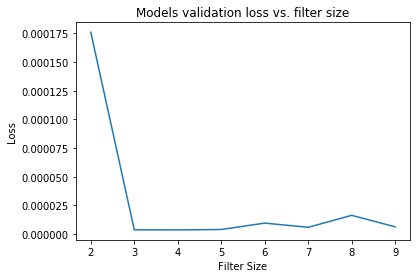

[0.0001760433897288749, 3.768289550028688e-06, 3.6609433967290292e-06, 4.0231569755633245e-06, 9.596947279533197e-06, 5.938012407114002e-06, 1.637789303761868e-05, 6.349043284596216e-06]


<Figure size 432x288 with 0 Axes>

In [9]:
print(modelsLoss)
print(modelsEpochs)

plt.plot(modelsLoss)
plt.title('Models validation loss vs. filter size')
plt.ylabel('Loss')
plt.xlabel('Filter Size')
plt.xticks(np.arange(8), [2,3,4,5,6,7,8,9])
plt.show()
print(modelsLoss)
plt.savefig('figures_differential/conv_filter_size_tuning.eps', format='eps', dpi=300, bbox_inches='tight')


In [ ]:
filterParam = modelsLoss.index(min(modelsLoss)) + 2

### 1-D Convolutional Network first layer filter count tuning


In [11]:
modelsLoss = []
modelsEpochs = []
for i in [4, 8, 12, 16, 20, 24, 28, 32, 36, 40, 44, 48]: 
    numOfLayers = depthParam
    filtersCountInFirstLayer = i
    [model, validatoinLoss, numOfEpochs, _] = train1DConv(numOfLayers, i, filterSize = filterParam)
    modelsLoss.append(validatoinLoss)
    modelsEpochs.append(numOfEpochs)

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_padding1d_14 (ZeroPaddi (None, 292, 1)            0         
_________________________________________________________________
conv1d_102 (Conv1D)          (None, 292, 4)            20        
_________________________________________________________________
max_pooling1d_32 (MaxPooling (None, 146, 4)            0         
_________________________________________________________________
conv1d_103 (Conv1D)          (None, 146, 8)            136       
_________________________________________________________________
max_pooling1d_33 (MaxPooling (None, 73, 8)             0         
_________________________________________________________________
conv1d_104 (Conv1D)          (None, 73, 16)            528       
_________________________________________________________________
flatten_14 (Flatten)         (None, 1168)            

43200/43200 [==============================] - 1s 33us/step - loss: 6.1160e-04 - val_loss: 6.2628e-04
Epoch 55/1000
43200/43200 [==============================] - 1s 33us/step - loss: 5.9321e-04 - val_loss: 5.7366e-04
Epoch 56/1000
43200/43200 [==============================] - 1s 32us/step - loss: 5.6325e-04 - val_loss: 5.5466e-04
Epoch 57/1000
43200/43200 [==============================] - 1s 33us/step - loss: 5.4631e-04 - val_loss: 5.3377e-04
Epoch 58/1000
43200/43200 [==============================] - 1s 33us/step - loss: 5.2494e-04 - val_loss: 5.1852e-04
Epoch 59/1000
43200/43200 [==============================] - 1s 33us/step - loss: 5.1057e-04 - val_loss: 4.9985e-04
Epoch 60/1000
43200/43200 [==============================] - 1s 32us/step - loss: 4.8971e-04 - val_loss: 4.8245e-04
Epoch 61/1000
43200/43200 [==============================] - 1s 32us/step - loss: 4.7343e-04 - val_loss: 4.6698e-04
Epoch 62/1000
43200/43200 [==============================] - 1s 32us/step - loss: 4.58

Epoch 194/1000
43200/43200 [==============================] - 1s 33us/step - loss: 1.1931e-04 - val_loss: 1.1303e-04
Epoch 195/1000
43200/43200 [==============================] - 1s 32us/step - loss: 1.1343e-04 - val_loss: 1.1470e-04
Epoch 196/1000
43200/43200 [==============================] - 1s 33us/step - loss: 1.1279e-04 - val_loss: 1.1260e-04
Epoch 197/1000
43200/43200 [==============================] - 1s 32us/step - loss: 1.1251e-04 - val_loss: 1.1182e-04
Epoch 198/1000
43200/43200 [==============================] - 1s 33us/step - loss: 1.1446e-04 - val_loss: 1.1135e-04
Epoch 199/1000
43200/43200 [==============================] - 1s 33us/step - loss: 1.1370e-04 - val_loss: 1.1211e-04
Epoch 200/1000
43200/43200 [==============================] - 1s 33us/step - loss: 1.1060e-04 - val_loss: 1.1031e-04
Epoch 201/1000
43200/43200 [==============================] - 1s 32us/step - loss: 1.1609e-04 - val_loss: 1.1802e-04
Epoch 202/1000
43200/43200 [==============================] - 1s

43200/43200 [==============================] - 1s 32us/step - loss: 8.6585e-05 - val_loss: 8.7049e-05
Epoch 265/1000
43200/43200 [==============================] - 1s 32us/step - loss: 8.6056e-05 - val_loss: 8.6845e-05
Epoch 266/1000
43200/43200 [==============================] - 1s 31us/step - loss: 8.9869e-05 - val_loss: 9.2932e-05
Epoch 267/1000
43200/43200 [==============================] - 1s 32us/step - loss: 8.7104e-05 - val_loss: 8.6470e-05
Epoch 268/1000
43200/43200 [==============================] - 1s 31us/step - loss: 8.5754e-05 - val_loss: 8.6087e-05
Epoch 269/1000
43200/43200 [==============================] - 1s 32us/step - loss: 8.9026e-05 - val_loss: 8.9331e-05
Epoch 270/1000
43200/43200 [==============================] - 1s 32us/step - loss: 8.6888e-05 - val_loss: 8.5891e-05
Epoch 271/1000
43200/43200 [==============================] - 1s 31us/step - loss: 8.5853e-05 - val_loss: 1.0370e-04
Epoch 272/1000
43200/43200 [==============================] - 1s 31us/step - lo

Epoch 334/1000
43200/43200 [==============================] - 1s 31us/step - loss: 7.4236e-05 - val_loss: 7.5426e-05
Epoch 335/1000
43200/43200 [==============================] - 1s 31us/step - loss: 7.1554e-05 - val_loss: 7.1287e-05
Epoch 336/1000
43200/43200 [==============================] - 1s 31us/step - loss: 7.0645e-05 - val_loss: 7.2425e-05
Epoch 337/1000
43200/43200 [==============================] - 1s 31us/step - loss: 7.9476e-05 - val_loss: 7.5343e-05
Epoch 338/1000
43200/43200 [==============================] - 1s 31us/step - loss: 7.1007e-05 - val_loss: 7.0782e-05
Epoch 339/1000
43200/43200 [==============================] - 1s 31us/step - loss: 6.9921e-05 - val_loss: 8.7552e-05
Epoch 340/1000
43200/43200 [==============================] - 1s 31us/step - loss: 7.4897e-05 - val_loss: 7.0909e-05
Epoch 341/1000
43200/43200 [==============================] - 1s 31us/step - loss: 6.9054e-05 - val_loss: 7.0244e-05
Epoch 342/1000
43200/43200 [==============================] - 1s

43200/43200 [==============================] - 1s 35us/step - loss: 5.6740e-05 - val_loss: 5.3329e-05
Epoch 88/1000
43200/43200 [==============================] - 1s 34us/step - loss: 5.8878e-05 - val_loss: 6.1883e-05
Epoch 89/1000
43200/43200 [==============================] - 1s 35us/step - loss: 5.6215e-05 - val_loss: 8.8888e-05
Epoch 90/1000
43200/43200 [==============================] - 2s 35us/step - loss: 7.0976e-05 - val_loss: 5.2680e-05
Epoch 91/1000
43200/43200 [==============================] - 2s 35us/step - loss: 5.0356e-05 - val_loss: 5.1248e-05
Epoch 92/1000
43200/43200 [==============================] - 2s 35us/step - loss: 5.7614e-05 - val_loss: 5.0471e-05
Epoch 93/1000
43200/43200 [==============================] - 2s 35us/step - loss: 4.9838e-05 - val_loss: 5.1657e-05
Epoch 94/1000
43200/43200 [==============================] - 2s 35us/step - loss: 8.4295e-05 - val_loss: 5.4123e-05
Epoch 95/1000
43200/43200 [==============================] - 2s 35us/step - loss: 4.91

43200/43200 [==============================] - 1s 34us/step - loss: 2.0573e-05 - val_loss: 2.4817e-05
Epoch 228/1000
43200/43200 [==============================] - 1s 35us/step - loss: 3.0525e-05 - val_loss: 2.0712e-05
Epoch 229/1000
43200/43200 [==============================] - 1s 35us/step - loss: 2.1390e-05 - val_loss: 3.8795e-05
Epoch 230/1000
43200/43200 [==============================] - 1s 35us/step - loss: 2.4337e-05 - val_loss: 2.0014e-05
Epoch 231/1000
43200/43200 [==============================] - 1s 34us/step - loss: 3.1664e-05 - val_loss: 2.2192e-05
Epoch 232/1000
43200/43200 [==============================] - 1s 35us/step - loss: 2.4960e-05 - val_loss: 2.0472e-05
Epoch 233/1000
43200/43200 [==============================] - 1s 35us/step - loss: 1.9544e-05 - val_loss: 1.9636e-05
Epoch 234/1000
43200/43200 [==============================] - 1s 34us/step - loss: 2.0907e-05 - val_loss: 3.7023e-05
Epoch 235/1000
43200/43200 [==============================] - 1s 34us/step - lo

43200/43200 [==============================] - 2s 38us/step - loss: 2.4775e-04 - val_loss: 2.3082e-04
Epoch 19/1000
43200/43200 [==============================] - 2s 38us/step - loss: 2.1739e-04 - val_loss: 2.1172e-04
Epoch 20/1000
43200/43200 [==============================] - 2s 38us/step - loss: 1.9276e-04 - val_loss: 1.8074e-04
Epoch 21/1000
43200/43200 [==============================] - 2s 38us/step - loss: 1.7214e-04 - val_loss: 1.7409e-04
Epoch 22/1000
43200/43200 [==============================] - 2s 38us/step - loss: 1.6294e-04 - val_loss: 1.5289e-04
Epoch 23/1000
43200/43200 [==============================] - 2s 38us/step - loss: 1.4278e-04 - val_loss: 1.3624e-04
Epoch 24/1000
43200/43200 [==============================] - 2s 38us/step - loss: 1.4545e-04 - val_loss: 1.2641e-04
Epoch 25/1000
43200/43200 [==============================] - 2s 38us/step - loss: 1.2053e-04 - val_loss: 1.1673e-04
Epoch 26/1000
43200/43200 [==============================] - 2s 38us/step - loss: 1.31

43200/43200 [==============================] - 2s 37us/step - loss: 2.3507e-05 - val_loss: 1.9868e-05
Epoch 159/1000
43200/43200 [==============================] - 2s 38us/step - loss: 2.2129e-05 - val_loss: 1.1530e-04
Epoch 160/1000
43200/43200 [==============================] - 2s 38us/step - loss: 3.3523e-05 - val_loss: 1.6928e-05
Epoch 161/1000
43200/43200 [==============================] - 2s 38us/step - loss: 1.6000e-05 - val_loss: 1.6270e-05
Epoch 162/1000
43200/43200 [==============================] - 2s 38us/step - loss: 2.1733e-05 - val_loss: 2.4163e-05
Epoch 163/1000
43200/43200 [==============================] - 2s 38us/step - loss: 1.8223e-05 - val_loss: 1.6864e-05
Epoch 164/1000
43200/43200 [==============================] - 2s 37us/step - loss: 3.4356e-05 - val_loss: 6.1305e-05
Epoch 165/1000
43200/43200 [==============================] - 2s 37us/step - loss: 2.2804e-05 - val_loss: 1.6398e-05
Epoch 166/1000
43200/43200 [==============================] - 2s 37us/step - lo

43200/43200 [==============================] - 2s 40us/step - loss: 4.6534e-05 - val_loss: 3.2732e-05
Epoch 90/1000
43200/43200 [==============================] - 2s 40us/step - loss: 2.9024e-05 - val_loss: 5.8396e-05
Epoch 91/1000
43200/43200 [==============================] - 2s 40us/step - loss: 4.3121e-05 - val_loss: 2.8818e-05
Epoch 92/1000
43200/43200 [==============================] - 2s 40us/step - loss: 4.4331e-05 - val_loss: 2.8936e-05
Epoch 93/1000
43200/43200 [==============================] - 2s 40us/step - loss: 2.6904e-05 - val_loss: 2.9284e-05
Epoch 94/1000
43200/43200 [==============================] - 2s 40us/step - loss: 6.9120e-05 - val_loss: 2.9710e-05
Epoch 95/1000
43200/43200 [==============================] - 2s 40us/step - loss: 2.6206e-05 - val_loss: 2.4784e-05
Epoch 96/1000
43200/43200 [==============================] - 2s 40us/step - loss: 3.4378e-05 - val_loss: 1.6132e-04
Epoch 97/1000
43200/43200 [==============================] - 2s 40us/step - loss: 4.31

43200/43200 [==============================] - 2s 45us/step - loss: 7.6248e-05 - val_loss: 3.7419e-05
Epoch 50/1000
43200/43200 [==============================] - 2s 45us/step - loss: 3.2217e-05 - val_loss: 3.0413e-05
Epoch 51/1000
43200/43200 [==============================] - 2s 45us/step - loss: 3.2720e-05 - val_loss: 9.2055e-05
Epoch 52/1000
43200/43200 [==============================] - 2s 45us/step - loss: 5.3308e-05 - val_loss: 3.1691e-05
Epoch 53/1000
43200/43200 [==============================] - 2s 45us/step - loss: 3.4163e-05 - val_loss: 5.8123e-05
Epoch 54/1000
43200/43200 [==============================] - 2s 45us/step - loss: 4.3067e-05 - val_loss: 3.4691e-05
Epoch 55/1000
43200/43200 [==============================] - 2s 45us/step - loss: 3.6703e-05 - val_loss: 2.8826e-05
Epoch 56/1000
43200/43200 [==============================] - 2s 45us/step - loss: 4.9013e-05 - val_loss: 3.1640e-05
Epoch 57/1000
43200/43200 [==============================] - 2s 45us/step - loss: 2.95

Epoch 189/1000
43200/43200 [==============================] - 2s 45us/step - loss: 2.1841e-05 - val_loss: 1.0352e-05
Epoch 190/1000
43200/43200 [==============================] - 2s 45us/step - loss: 7.8384e-06 - val_loss: 7.5708e-06
Epoch 191/1000
43200/43200 [==============================] - 2s 45us/step - loss: 4.7000e-05 - val_loss: 1.9786e-05
Epoch 192/1000
43200/43200 [==============================] - 2s 45us/step - loss: 9.6037e-06 - val_loss: 7.2746e-06
Epoch 193/1000
43200/43200 [==============================] - 2s 45us/step - loss: 6.9770e-06 - val_loss: 7.2660e-06
Epoch 194/1000
43200/43200 [==============================] - 2s 45us/step - loss: 1.0367e-05 - val_loss: 6.7252e-05
Epoch 195/1000
43200/43200 [==============================] - 2s 45us/step - loss: 2.3218e-05 - val_loss: 7.4698e-06
Epoch 196/1000
43200/43200 [==============================] - 2s 45us/step - loss: 6.9497e-06 - val_loss: 6.9242e-06
Epoch 197/1000
43200/43200 [==============================] - 2s

Epoch 259/1000
43200/43200 [==============================] - 2s 45us/step - loss: 4.4874e-06 - val_loss: 4.6283e-06
Epoch 260/1000
43200/43200 [==============================] - 2s 45us/step - loss: 1.5087e-05 - val_loss: 6.8656e-06
Epoch 261/1000
43200/43200 [==============================] - 2s 45us/step - loss: 5.7784e-06 - val_loss: 4.5800e-06
Epoch 262/1000
43200/43200 [==============================] - 2s 45us/step - loss: 1.1646e-05 - val_loss: 5.6286e-06
Epoch 263/1000
43200/43200 [==============================] - 2s 45us/step - loss: 8.2336e-06 - val_loss: 2.6298e-05
Epoch 264/1000
43200/43200 [==============================] - 2s 45us/step - loss: 9.4871e-06 - val_loss: 6.0999e-06
Epoch 265/1000
43200/43200 [==============================] - 2s 45us/step - loss: 2.1253e-05 - val_loss: 3.4338e-05
Epoch 266/1000
43200/43200 [==============================] - 2s 45us/step - loss: 1.1074e-05 - val_loss: 4.9225e-06
Epoch 267/1000
43200/43200 [==============================] - 2s

43200/43200 [==============================] - 2s 48us/step - loss: 1.0738e-04 - val_loss: 8.5689e-05
Epoch 20/1000
43200/43200 [==============================] - 2s 49us/step - loss: 9.7655e-05 - val_loss: 3.6868e-04
Epoch 21/1000
43200/43200 [==============================] - 2s 48us/step - loss: 1.0498e-04 - val_loss: 6.8563e-05
Epoch 22/1000
43200/43200 [==============================] - 2s 48us/step - loss: 6.3686e-05 - val_loss: 6.1069e-05
Epoch 23/1000
43200/43200 [==============================] - 2s 48us/step - loss: 7.6970e-05 - val_loss: 3.0972e-04
Epoch 24/1000
43200/43200 [==============================] - 2s 48us/step - loss: 8.5600e-05 - val_loss: 5.6352e-05
Epoch 25/1000
43200/43200 [==============================] - 2s 48us/step - loss: 5.3258e-05 - val_loss: 5.2428e-05
Epoch 26/1000
43200/43200 [==============================] - 2s 48us/step - loss: 8.3179e-05 - val_loss: 6.5872e-05
Epoch 27/1000
43200/43200 [==============================] - 2s 48us/step - loss: 6.03

43200/43200 [==============================] - 2s 49us/step - loss: 1.9952e-05 - val_loss: 2.7599e-05
Epoch 160/1000
43200/43200 [==============================] - 2s 48us/step - loss: 1.4122e-05 - val_loss: 8.6811e-06
Epoch 161/1000
43200/43200 [==============================] - 2s 49us/step - loss: 6.5486e-05 - val_loss: 4.5742e-05
Epoch 162/1000
43200/43200 [==============================] - 2s 48us/step - loss: 1.6492e-05 - val_loss: 9.8669e-06
Epoch 163/1000
43200/43200 [==============================] - 2s 48us/step - loss: 9.1028e-06 - val_loss: 1.0466e-05
Epoch 164/1000
43200/43200 [==============================] - 2s 49us/step - loss: 3.7165e-05 - val_loss: 1.4667e-05
Epoch 165/1000
43200/43200 [==============================] - 2s 48us/step - loss: 9.4525e-06 - val_loss: 8.5045e-06
Epoch 166/1000
43200/43200 [==============================] - 2s 49us/step - loss: 8.1428e-06 - val_loss: 8.2388e-06
Epoch 167/1000
43200/43200 [==============================] - 2s 48us/step - lo

Train on 43200 samples, validate on 4800 samples
Epoch 1/1000
43200/43200 [==============================] - 4s 97us/step - loss: 0.0501 - val_loss: 0.0292
Epoch 2/1000
43200/43200 [==============================] - 2s 52us/step - loss: 0.0288 - val_loss: 0.0285
Epoch 3/1000
43200/43200 [==============================] - 2s 52us/step - loss: 0.0195 - val_loss: 0.0050
Epoch 4/1000
43200/43200 [==============================] - 2s 52us/step - loss: 0.0030 - val_loss: 0.0022
Epoch 5/1000
43200/43200 [==============================] - 2s 52us/step - loss: 0.0020 - val_loss: 0.0018
Epoch 6/1000
43200/43200 [==============================] - 2s 53us/step - loss: 0.0014 - val_loss: 0.0012
Epoch 7/1000
43200/43200 [==============================] - 2s 52us/step - loss: 0.0011 - val_loss: 0.0010
Epoch 8/1000
43200/43200 [==============================] - 2s 53us/step - loss: 9.8509e-04 - val_loss: 8.7841e-04
Epoch 9/1000
43200/43200 [==============================] - 2s 53us/step - loss: 7.8178

Epoch 72/1000
43200/43200 [==============================] - 2s 53us/step - loss: 7.7009e-05 - val_loss: 3.1250e-05
Epoch 73/1000
43200/43200 [==============================] - 2s 53us/step - loss: 2.0956e-05 - val_loss: 1.7603e-05
Epoch 74/1000
43200/43200 [==============================] - 2s 53us/step - loss: 1.8000e-05 - val_loss: 3.1150e-05
Epoch 75/1000
43200/43200 [==============================] - 2s 53us/step - loss: 5.8367e-05 - val_loss: 2.0467e-05
Epoch 76/1000
43200/43200 [==============================] - 2s 53us/step - loss: 1.7114e-05 - val_loss: 1.9448e-05
Epoch 77/1000
43200/43200 [==============================] - 2s 52us/step - loss: 6.1817e-05 - val_loss: 2.5286e-05
Epoch 78/1000
43200/43200 [==============================] - 2s 52us/step - loss: 1.7009e-05 - val_loss: 1.7179e-05
Epoch 79/1000
43200/43200 [==============================] - 2s 52us/step - loss: 5.0306e-05 - val_loss: 3.2444e-05
Epoch 80/1000
43200/43200 [==============================] - 2s 53us/ste

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_padding1d_21 (ZeroPaddi (None, 292, 1)            0         
_________________________________________________________________
conv1d_151 (Conv1D)          (None, 292, 32)           160       
_________________________________________________________________
max_pooling1d_46 (MaxPooling (None, 146, 32)           0         
_________________________________________________________________
conv1d_152 (Conv1D)          (None, 146, 64)           8256      
_________________________________________________________________
max_pooling1d_47 (MaxPooling (None, 73, 64)            0         
_________________________________________________________________
conv1d_153 (Conv1D)          (None, 73, 128)           32896     
_________________________________________________________________
flatten_21 (Flatten)         (None, 9344)            

43200/43200 [==============================] - 2s 56us/step - loss: 3.6682e-05 - val_loss: 2.0081e-05
Epoch 122/1000
43200/43200 [==============================] - 2s 56us/step - loss: 1.2340e-05 - val_loss: 8.1597e-06
Epoch 123/1000
43200/43200 [==============================] - 2s 56us/step - loss: 7.7222e-06 - val_loss: 1.1609e-05
Epoch 124/1000
43200/43200 [==============================] - 2s 56us/step - loss: 3.9324e-05 - val_loss: 9.3401e-06
Epoch 125/1000
43200/43200 [==============================] - 2s 56us/step - loss: 7.8621e-06 - val_loss: 8.5477e-06
Epoch 126/1000
43200/43200 [==============================] - 2s 56us/step - loss: 2.3868e-05 - val_loss: 1.6203e-05
Epoch 127/1000
43200/43200 [==============================] - 2s 57us/step - loss: 1.2401e-05 - val_loss: 4.7829e-05
Epoch 128/1000
43200/43200 [==============================] - 2s 56us/step - loss: 2.9064e-05 - val_loss: 8.5742e-06
Epoch 00128: early stopping
Model: "sequential_22"
____________________________

43200/43200 [==============================] - 3s 69us/step - loss: 7.5822e-06 - val_loss: 7.7246e-06
Epoch 114/1000
43200/43200 [==============================] - 3s 69us/step - loss: 1.6244e-05 - val_loss: 1.5480e-04
Epoch 115/1000
43200/43200 [==============================] - 3s 68us/step - loss: 3.9471e-05 - val_loss: 9.4406e-06
Epoch 116/1000
43200/43200 [==============================] - 3s 69us/step - loss: 7.6577e-06 - val_loss: 7.4327e-06
Epoch 117/1000
43200/43200 [==============================] - 3s 69us/step - loss: 5.6051e-05 - val_loss: 2.8705e-05
Epoch 118/1000
43200/43200 [==============================] - 3s 69us/step - loss: 1.3872e-05 - val_loss: 8.0024e-06
Epoch 119/1000
43200/43200 [==============================] - 3s 69us/step - loss: 7.1529e-06 - val_loss: 7.2358e-06
Epoch 120/1000
43200/43200 [==============================] - 3s 69us/step - loss: 6.4322e-05 - val_loss: 3.8121e-05
Epoch 121/1000
43200/43200 [==============================] - 3s 69us/step - lo

Epoch 10/1000
43200/43200 [==============================] - 3s 72us/step - loss: 2.3944e-04 - val_loss: 2.1004e-04
Epoch 11/1000
43200/43200 [==============================] - 3s 72us/step - loss: 1.7731e-04 - val_loss: 2.7203e-04
Epoch 12/1000
43200/43200 [==============================] - 3s 72us/step - loss: 1.4223e-04 - val_loss: 1.0871e-04
Epoch 13/1000
43200/43200 [==============================] - 3s 73us/step - loss: 1.1929e-04 - val_loss: 9.9866e-05
Epoch 14/1000
43200/43200 [==============================] - 3s 72us/step - loss: 9.3398e-05 - val_loss: 8.5643e-05
Epoch 15/1000
43200/43200 [==============================] - 3s 72us/step - loss: 9.8315e-05 - val_loss: 1.0754e-04
Epoch 16/1000
43200/43200 [==============================] - 3s 72us/step - loss: 7.0192e-05 - val_loss: 5.1907e-05
Epoch 17/1000
43200/43200 [==============================] - 3s 72us/step - loss: 5.6530e-05 - val_loss: 1.9246e-04
Epoch 18/1000
43200/43200 [==============================] - 3s 72us/ste

Train on 43200 samples, validate on 4800 samples
Epoch 1/1000
43200/43200 [==============================] - 5s 122us/step - loss: 0.0556 - val_loss: 0.0291
Epoch 2/1000
43200/43200 [==============================] - 3s 77us/step - loss: 0.0269 - val_loss: 0.0118
Epoch 3/1000
43200/43200 [==============================] - 3s 77us/step - loss: 0.0035 - val_loss: 0.0021
Epoch 4/1000
43200/43200 [==============================] - 3s 77us/step - loss: 0.0018 - val_loss: 0.0014
Epoch 5/1000
43200/43200 [==============================] - 3s 77us/step - loss: 0.0011 - val_loss: 0.0010
Epoch 6/1000
43200/43200 [==============================] - 3s 77us/step - loss: 0.0010 - val_loss: 9.3720e-04
Epoch 7/1000
43200/43200 [==============================] - 3s 78us/step - loss: 8.8775e-04 - val_loss: 7.3084e-04
Epoch 8/1000
43200/43200 [==============================] - 3s 77us/step - loss: 6.2025e-04 - val_loss: 4.4394e-04
Epoch 9/1000
43200/43200 [==============================] - 3s 77us/step -

43200/43200 [==============================] - 3s 77us/step - loss: 1.1065e-05 - val_loss: 1.7624e-04
Epoch 142/1000
43200/43200 [==============================] - 3s 77us/step - loss: 3.7176e-05 - val_loss: 3.9037e-06
Epoch 143/1000
43200/43200 [==============================] - 3s 77us/step - loss: 3.4730e-06 - val_loss: 3.3194e-06
Epoch 144/1000
43200/43200 [==============================] - 3s 77us/step - loss: 5.8173e-06 - val_loss: 6.0998e-05
Epoch 145/1000
43200/43200 [==============================] - 3s 77us/step - loss: 3.3066e-05 - val_loss: 5.1240e-06
Epoch 146/1000
43200/43200 [==============================] - 3s 77us/step - loss: 3.5384e-06 - val_loss: 3.1092e-06
Epoch 147/1000
43200/43200 [==============================] - 3s 77us/step - loss: 3.6443e-05 - val_loss: 1.7423e-05
Epoch 148/1000
43200/43200 [==============================] - 3s 77us/step - loss: 2.3091e-05 - val_loss: 4.0692e-06
Epoch 149/1000
43200/43200 [==============================] - 3s 77us/step - lo

43200/43200 [==============================] - 4s 81us/step - loss: 2.0007e-05 - val_loss: 1.1324e-04
Epoch 106/1000
43200/43200 [==============================] - 4s 81us/step - loss: 1.9508e-05 - val_loss: 5.2937e-06
Epoch 107/1000
43200/43200 [==============================] - 3s 81us/step - loss: 5.2691e-06 - val_loss: 6.9844e-06
Epoch 108/1000
43200/43200 [==============================] - 3s 81us/step - loss: 4.4245e-05 - val_loss: 1.2324e-05
Epoch 109/1000
43200/43200 [==============================] - 4s 81us/step - loss: 6.3254e-06 - val_loss: 4.7319e-06
Epoch 110/1000
43200/43200 [==============================] - 4s 81us/step - loss: 5.4686e-06 - val_loss: 2.7722e-05
Epoch 111/1000
43200/43200 [==============================] - 4s 81us/step - loss: 5.6073e-05 - val_loss: 8.5285e-06
Epoch 112/1000
43200/43200 [==============================] - 4s 81us/step - loss: 5.2305e-06 - val_loss: 4.5877e-06
Epoch 113/1000
43200/43200 [==============================] - 4s 82us/step - lo

[6.749173644493567e-05, 1.3900788530918362e-05, 1.4584769587600022e-05, 1.519950141452379e-05, 3.940822125514387e-06, 6.06398733301224e-06, 4.0530157813615615e-06, 8.012689439359141e-06, 2.9589559839375093e-06, 4.152041223430085e-06, 3.1091566180900068e-06, 1.7140224078578588e-06]
[367, 329, 189, 160, 290, 208, 211, 128, 223, 147, 156, 209]


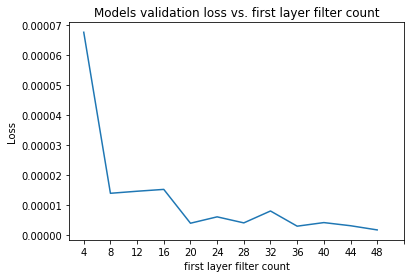

[6.749173644493567e-05, 1.3900788530918362e-05, 1.4584769587600022e-05, 1.519950141452379e-05, 3.940822125514387e-06, 6.06398733301224e-06, 4.0530157813615615e-06, 8.012689439359141e-06, 2.9589559839375093e-06, 4.152041223430085e-06, 3.1091566180900068e-06, 1.7140224078578588e-06]


In [12]:
print(modelsLoss)
print(modelsEpochs)

plt.plot(modelsLoss)
plt.title('Models validation loss vs. first layer filter count')
plt.ylabel('Loss')
plt.xlabel('first layer filter count')
plt.xticks(np.arange(13), [4, 8, 12, 16, 20, 24, 28, 32, 36, 40, 44, 48])
plt.show()
print(modelsLoss)